In [463]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [565]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [566]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = list(predictions.location.unique())
loclist.remove('US')

In [567]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = datetime.datetime(2022, 3, 15)
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]

In [585]:
median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['Model', 'WIS','50% Coverage','95% Coverage', 'Location', 'Population','Label'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    #target = 'death'
    #target = 'hosp'
    target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme Aggregate"]

        


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            for label in ["Median aggregate"]:
                aggregated_data['Case'] += [label]
                aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
                aggregated_data['Cov50'] += [aggregated_scores[label]['50_cov']]
                aggregated_data['Cov95'] += [aggregated_scores[label]['95_cov']]

                agg_data_df = pd.DataFrame(aggregated_data)
                agg_data_df['Model'] = model
                wisval = agg_data_df.WIS[0]
                cov50val = agg_data_df.Cov50[0]
                cov95val = agg_data_df.Cov95[0]

            
            locname = list(pred.location_name.unique())[0]
            popsize = list(pred.population.unique())[0]


            new_row = {'Model':model, 'WIS':wisval,'50% Coverage':cov50val, '95% Coverage':cov95val,
                       'Location': locname, 'Population': popsize, 'Label':label}
 
            df = df.append(new_row, ignore_index=True)
            
            
  
        except Exception as e:
            print(e)    
    


/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:34: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fals

There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NotreDame-FRED at location 01


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 01


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NotreDame-FRED at location 02


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 02


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NotreDame-FRED at location 04


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 04


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NotreDame-FRED at location 05


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 05


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NotreDame-FRED at location 06


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model NotreDame-FRED at location 08


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 08


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 09
There are no predictions for model NotreDame-FRED at location 09


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 09


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 10
There are no predictions for model NotreDame-FRED at location 10


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 10


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 11
There are no predictions for model NotreDame-FRED at location 11


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 11


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 12
There are no predictions for model NotreDame-FRED at location 12


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 13
There are no predictions for model NotreDame-FRED at location 13


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 13


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 15
There are no predictions for model NotreDame-FRED at location 15


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 15


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 16
There are no predictions for model NotreDame-FRED at location 16


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 16


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 17
There are no predictions for model NotreDame-FRED at location 17


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 17


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 18


/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model UTA-ImmunoSEIRS at location 18


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 19
There are no predictions for model NotreDame-FRED at location 19


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 19


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 20
There are no predictions for model NotreDame-FRED at location 20


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 20


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 21
There are no predictions for model NotreDame-FRED at location 21


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 21


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 22
There are no predictions for model NotreDame-FRED at location 22


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 22


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 23
There are no predictions for model NotreDame-FRED at location 23


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 23


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 24
There are no predictions for model NotreDame-FRED at location 24


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 24


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 25
There are no predictions for model NotreDame-FRED at location 25


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 26
There are no predictions for model NotreDame-FRED at location 26


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 26


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 27
There are no predictions for model NotreDame-FRED at location 27


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 27


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 28
There are no predictions for model NotreDame-FRED at location 28


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 28


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 29
There are no predictions for model NotreDame-FRED at location 29


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 29


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 30
There are no predictions for model NotreDame-FRED at location 30


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 30


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 31
There are no predictions for model NotreDame-FRED at location 31


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 31


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 32
There are no predictions for model NotreDame-FRED at location 32


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 32


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 33
There are no predictions for model NotreDame-FRED at location 33


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 33


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 34
There are no predictions for model NotreDame-FRED at location 34


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 34


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 35
There are no predictions for model NotreDame-FRED at location 35


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 35


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 36
There are no predictions for model NotreDame-FRED at location 36


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 36


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 37
There are no predictions for model NotreDame-FRED at location 37


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 37


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 38
There are no predictions for model NotreDame-FRED at location 38


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 38


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 39
There are no predictions for model NotreDame-FRED at location 39


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 39


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 40
There are no predictions for model NotreDame-FRED at location 40


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 40


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 41
There are no predictions for model NotreDame-FRED at location 41


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 41


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 42
There are no predictions for model NotreDame-FRED at location 42


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 42


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 44
There are no predictions for model NotreDame-FRED at location 44


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 44


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 45
There are no predictions for model NotreDame-FRED at location 45


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 45


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 46
There are no predictions for model NotreDame-FRED at location 46


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 46


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 47
There are no predictions for model NotreDame-FRED at location 47


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 47


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 48
There are no predictions for model NotreDame-FRED at location 48


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 49
There are no predictions for model NotreDame-FRED at location 49


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 49


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 50
There are no predictions for model NotreDame-FRED at location 50


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 50


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 51
There are no predictions for model NotreDame-FRED at location 51


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 51


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 53
There are no predictions for model NotreDame-FRED at location 53


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 53


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 54
There are no predictions for model NotreDame-FRED at location 54


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 54


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 55
There are no predictions for model NotreDame-FRED at location 55


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 55


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/285071664.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[q

There are no predictions for model NCSU-COVSIM at location 56
There are no predictions for model NotreDame-FRED at location 56


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location 56


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

In [578]:
df

,Model,WIS,50% Coverage,95% Coverage,Location,Population,Label
0,Ensemble,128.222697,0.000000,0.444444,Alabama,4903185,Median aggregate
1,Ensemble_LOP,106.969954,0.111111,0.888889,Alabama,4903185,Median aggregate
2,Ensemble_LOP_untrimmed,111.559552,0.444444,1.000000,Alabama,4903185,Median aggregate
3,JHU_IDD-CovidSP,164.616143,0.111111,0.333333,Alabama,4903185,Median aggregate
4,MOBS_NEU-GLEAM_COVID,85.907343,0.333333,0.777778,Alabama,4903185,Median aggregate
...,...,...,...,...,...,...,...
459,MOBS_NEU-GLEAM_COVID,4.653105,0.555556,1.000000,Wyoming,578759,Median aggregate
460,UNCC-hierbin,12.849400,0.000000,0.222222,Wyoming,578759,Median aggregate
461,USC-SIkJalpha,73.493314,0.111111,0.333333,Wyoming,578759,Median aggregate
462,UVA-EpiHiper,17.105716,0.000000,0.666667,Wyoming,578759,Median aggregate


In [586]:
median_ensembles_all_case = median_ensembles
extreme_ensembles_all_case = extreme_ensembles

df_all_case = df

In [587]:
df_all_hosp.to_pickle('df_all_hosp.pkl') 
df_all_death.to_pickle('df_all_death.pkl')
df_all_case.to_pickle('df_all_case.pkl')

In [144]:
def check_coherence(predictions): 
    quantiles = predictions['quantile'].dropna().unique()
    qlist = quantiles[quantiles < 0.5]
    qlist_ = list(reversed(quantiles[quantiles > 0.5]))
    for i,q in enumerate(qlist):
        low = predictions[(predictions['quantile'] == q) & (predictions['location'] == 'US')].sort_values(
            by=['target_end_date'])
        up = predictions[(predictions['quantile'] == qlist_[i]) & (predictions['location'] == 'US')].sort_values(
            by=['target_end_date'])
        if not all((up['value'].to_numpy() - low['value'].to_numpy()) > 0):
            raise RuntimeError(f"quantile {q} and {qlist_[i]} now well conditioned")

In [448]:
df_all_case.head(10)

,Model,WIS,50% Coverage,95% Coverage,Location,Population
0,Ensemble,13296.525920,0.555556,0.888889,Alabama,4903185
1,Ensemble_LOP,12168.517187,0.888889,1.000000,Alabama,4903185
2,Ensemble_LOP_untrimmed,14887.529427,0.888889,1.000000,Alabama,4903185
3,JHU_IDD-CovidSP,13540.737598,0.444444,1.000000,Alabama,4903185
4,MOBS_NEU-GLEAM_COVID,8999.829219,0.333333,0.666667,Alabama,4903185
5,UNCC-hierbin,26562.129311,0.000000,0.111111,Alabama,4903185
6,USC-SIkJalpha,64207.627879,0.111111,0.222222,Alabama,4903185
7,UVA-EpiHiper,37023.165824,0.111111,0.444444,Alabama,4903185
8,UVA-adaptive,23054.223645,0.111111,0.222222,Alabama,4903185
9,Ensemble,1805.620254,0.555556,1.000000,Alaska,731545


In [588]:
df_all_case.head(10)

,Model,WIS,50% Coverage,95% Coverage,Location,Population,Label
0,Ensemble,12953.849139,0.666667,0.888889,Alabama,4903185,Median aggregate
1,Ensemble_LOP,11988.337519,0.888889,1.000000,Alabama,4903185,Median aggregate
2,Ensemble_LOP_untrimmed,14195.242007,0.888889,1.000000,Alabama,4903185,Median aggregate
3,JHU_IDD-CovidSP,11580.590399,0.888889,1.000000,Alabama,4903185,Median aggregate
4,MOBS_NEU-GLEAM_COVID,11230.877077,0.333333,0.555556,Alabama,4903185,Median aggregate
5,UNCC-hierbin,26739.328206,0.000000,0.111111,Alabama,4903185,Median aggregate
6,USC-SIkJalpha,57416.689944,0.000000,0.222222,Alabama,4903185,Median aggregate
7,UVA-EpiHiper,34138.202060,0.111111,0.444444,Alabama,4903185,Median aggregate
8,UVA-adaptive,21758.091058,0.111111,0.222222,Alabama,4903185,Median aggregate
9,Ensemble,1816.181579,0.555556,1.000000,Alaska,731545,Median aggregate


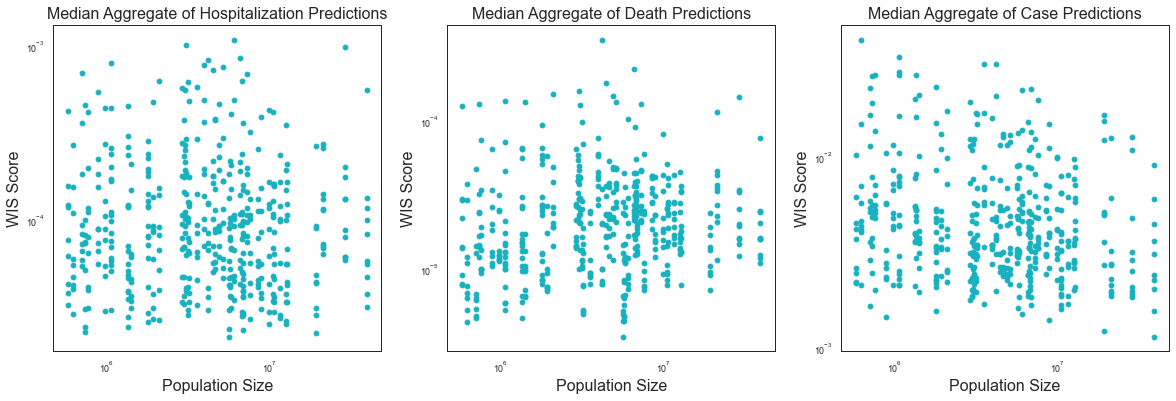

In [589]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.loglog(df_all_hosp['Population'],df_all_hosp['WIS']/df_all_hosp['Population'], 'o',  color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Hospitalization Predictions', fontsize=16)


plt.subplot(1,3,2)
plt.loglog(df_all_death['Population'],df_all_death['WIS']/df_all_death['Population'], 'o', color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Death Predictions', fontsize=16)


plt.subplot(1,3,3)
plt.loglog(df_all_case['Population'],df_all_case['WIS']/df_all_case['Population'], 'o', color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Case Predictions', fontsize=16)


plt.show()

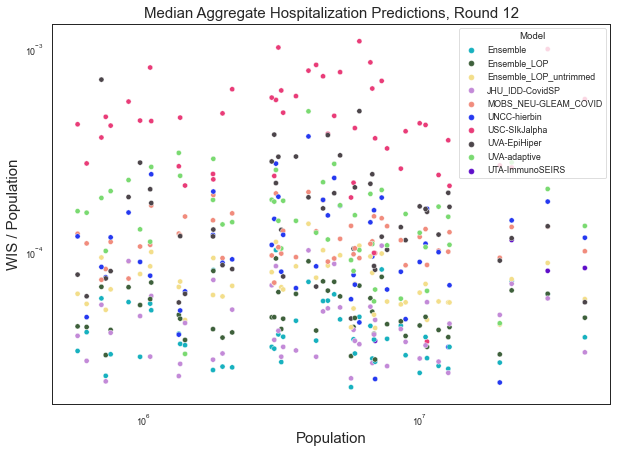

In [615]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']/df_all_hosp['Population']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wispop_hosp.pdf')
plt.show()

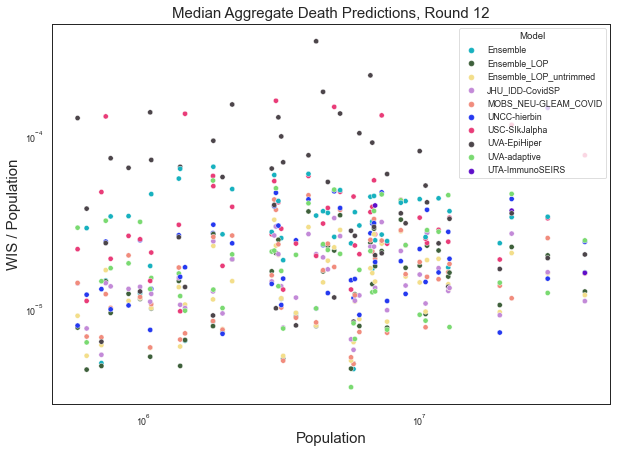

In [616]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_hosp, x=df_all_death['Population'],
                y=df_all_death['WIS']/df_all_death['Population'],
                hue='Model', s=27 ).set(title='Median Aggregate Death Predictions, Round 12')
ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wispop_death.pdf')
plt.show()

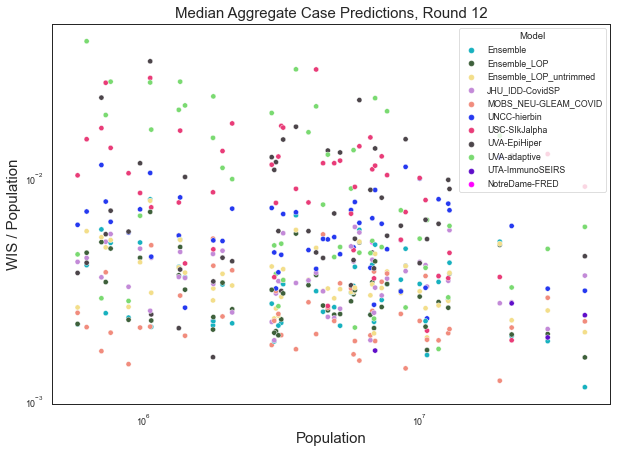

In [617]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta', 'coral']
sns.set_palette(flatui)

#sns.set_style("white")
#sns.axes_style("white")
#sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_case, x=df_all_case['Population'],
                y=df_all_case['WIS']/df_all_case['Population'],
                hue='Model', s=27).set(title='Median Aggregate Case Predictions, Round 12')

ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wispop_case.pdf')
plt.show()

In [785]:
from scipy.stats import linregress

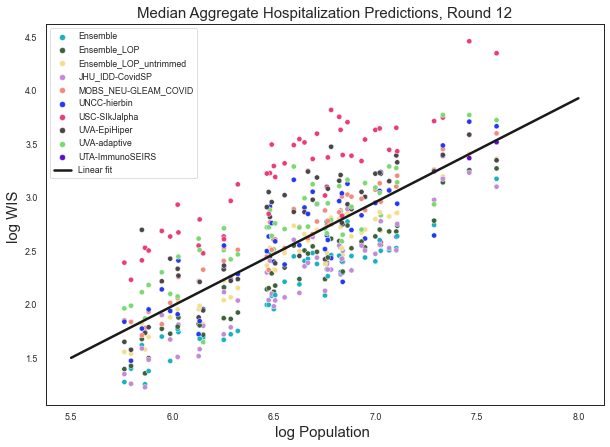

In [811]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=np.log10(df_all_hosp['Population'].astype('float64')),
                y=np.log10(df_all_hosp['WIS'])
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')

slope, intercept, r_value, p_value, std_err = linregress(np.log10(df_all_hosp['Population'].astype('float64')),
                                                         np.log10(df_all_hosp['WIS']))

xfid = np.linspace(5.5, 8)     # This is just a set of x to plot the straight line 

plt.plot(xfid, xfid*slope+intercept,'k',label='Linear fit',lw=2.5)


plt.legend()
ax.set( ylabel='log WIS ')
ax.set( xlabel='log Population ')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_hosp_unnormalized_linfit.pdf')
plt.show()

In [812]:
slope

0.9712244647055152

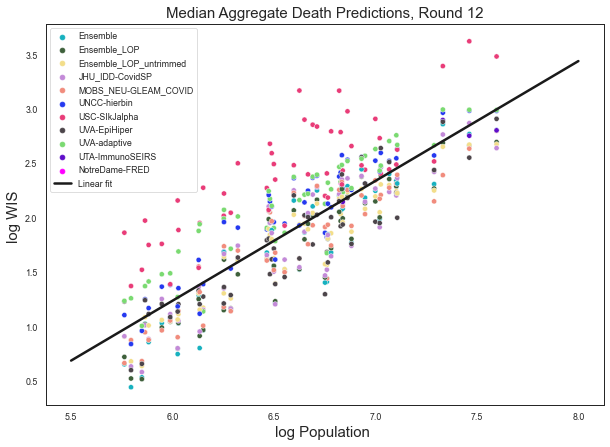

In [809]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9', 'magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_death, x=np.log10(df_all_death['Population'].astype('float64')),
                y=np.log10(df_all_death['WIS']),
                hue='Model', s=27 ).set(title='Median Aggregate Death Predictions, Round 12')

#b, a = np.polyfit(np.log10(df_all_death['Population'].astype('float64')), np.log10(df_all_death['WIS']), deg=1)

# Create sequence of 100 numbers from 0 to 100 
#xseq = np.linspace(500000, 50000000, num=100)

# Plot regression line
#ax.plot(np.log10(xseq), a + b * np.log10(xseq), color="k", lw=2.5, label='Linear fit');


slope, intercept, r_value, p_value, std_err = linregress(np.log10(df_all_death['Population'].astype('float64')),
                                                         np.log10(df_all_death['WIS']))

xfid = np.linspace(5.5, 8)     # This is just a set of x to plot the straight line 

plt.plot(xfid, xfid*slope+intercept,'k',label='Linear fit',lw=2.5)


plt.legend()
ax.set( ylabel='log WIS ')
ax.set( xlabel='log Population ')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_death_unnormalized_linfit.pdf')
plt.show()

In [810]:
slope

1.1010280676678506

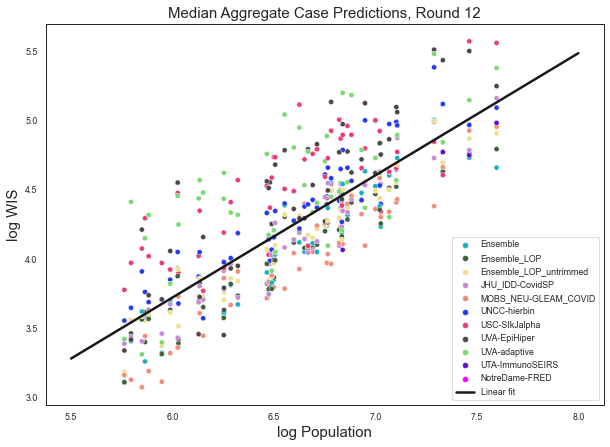

In [799]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta', 'coral']
sns.set_palette(flatui)

#sns.set_style("white")
#sns.axes_style("white")
#sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_case, x=np.log10(df_all_case['Population'].astype('float64')),
                y=np.log10(df_all_case['WIS']),
                hue='Model', s=27).set(title='Median Aggregate Case Predictions, Round 12')


slope, intercept, r_value, p_value, std_err = linregress(np.log10(df_all_case['Population'].astype('float64')),
                                                         np.log10(df_all_case['WIS']))

xfid = np.linspace(5.5, 8)     # This is just a set of x to plot the straight line 

plt.plot(xfid, xfid*slope+intercept,'k',label='Linear fit',lw=2.5)



plt.legend()
ax.set( ylabel='log WIS')
ax.set( xlabel='log Population')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_case_unnormalized_linfit.pdf')
plt.show()

In [808]:
slope

0.8823631599324231

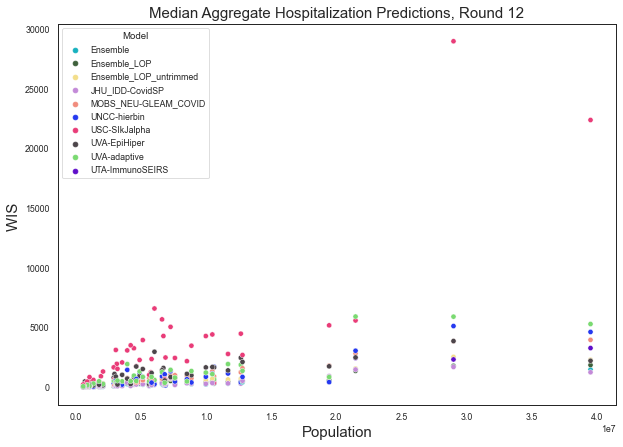

In [625]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS ')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_hosp_unnormalized_linlin.pdf')
plt.show()

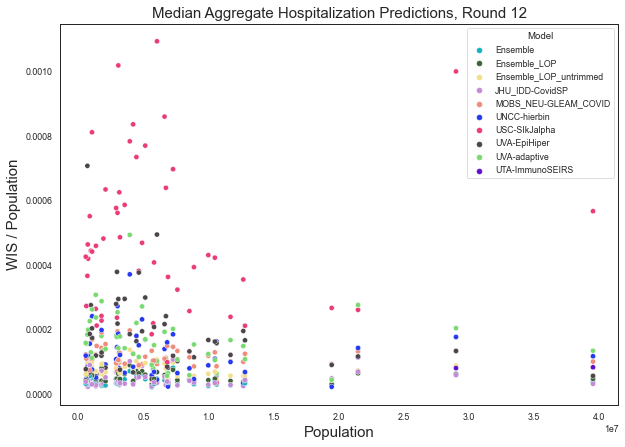

In [627]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']/df_all_hosp['Population']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS / Population')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_hosp_linlin.pdf')
plt.show()

# Ranking Distributions

In [604]:
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","UNCC-hierbin","USC-SIkJalpha",
           "UVA-EpiHiper","UVA-adaptive"]

dfrank = pd.DataFrame(columns=['Model', 'Location', 'Rank'])

states = list(df_all_hosp.Location.unique())
target = 'case'

if target == 'hosp':
    df = df_all_hosp
elif target == 'death':
    df = df_all_death
elif target == 'case':
    df = df_all_case
    
    
for state in states:
    filt = df[df['Location']==state]
    filt = filt.sort_values('WIS')

    rank = list(filt.Model)
    for model in models:
        if model not in rank:
            continue
        rankval = rank.index(model)+1
        
        new_row = {'Model':model, 'Location': state, 'Rank': rankval}
 
        dfrank = dfrank.append(new_row, ignore_index=True)

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2623011640.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfrank = dfrank.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2623011640.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfrank = dfrank.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2623011640.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfrank = dfrank.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2623011640.py:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use 

In [605]:
dfrank_case = dfrank

In [489]:
dfrank_case.head(10)

,Model,Location,Rank
0,Ensemble,Alabama,3
1,Ensemble_LOP,Alabama,2
2,Ensemble_LOP_untrimmed,Alabama,5
3,JHU_IDD-CovidSP,Alabama,4
4,MOBS_NEU-GLEAM_COVID,Alabama,1
5,UNCC-hierbin,Alabama,7
6,USC-SIkJalpha,Alabama,9
7,UVA-EpiHiper,Alabama,8
8,UVA-adaptive,Alabama,6
9,Ensemble,Alaska,1


In [330]:
dfrank_death.head(10)

,Model,Location,Rank
0,Ensemble,Alabama,5
1,Ensemble_LOP,Alabama,3
2,Ensemble_LOP_untrimmed,Alabama,2
3,JHU_IDD-CovidSP,Alabama,6
4,MOBS_NEU-GLEAM_COVID,Alabama,4
5,UNCC-hierbin,Alabama,7
6,USC-SIkJalpha,Alabama,9
7,UVA-EpiHiper,Alabama,1
8,UVA-adaptive,Alabama,8
9,Ensemble,Alaska,4


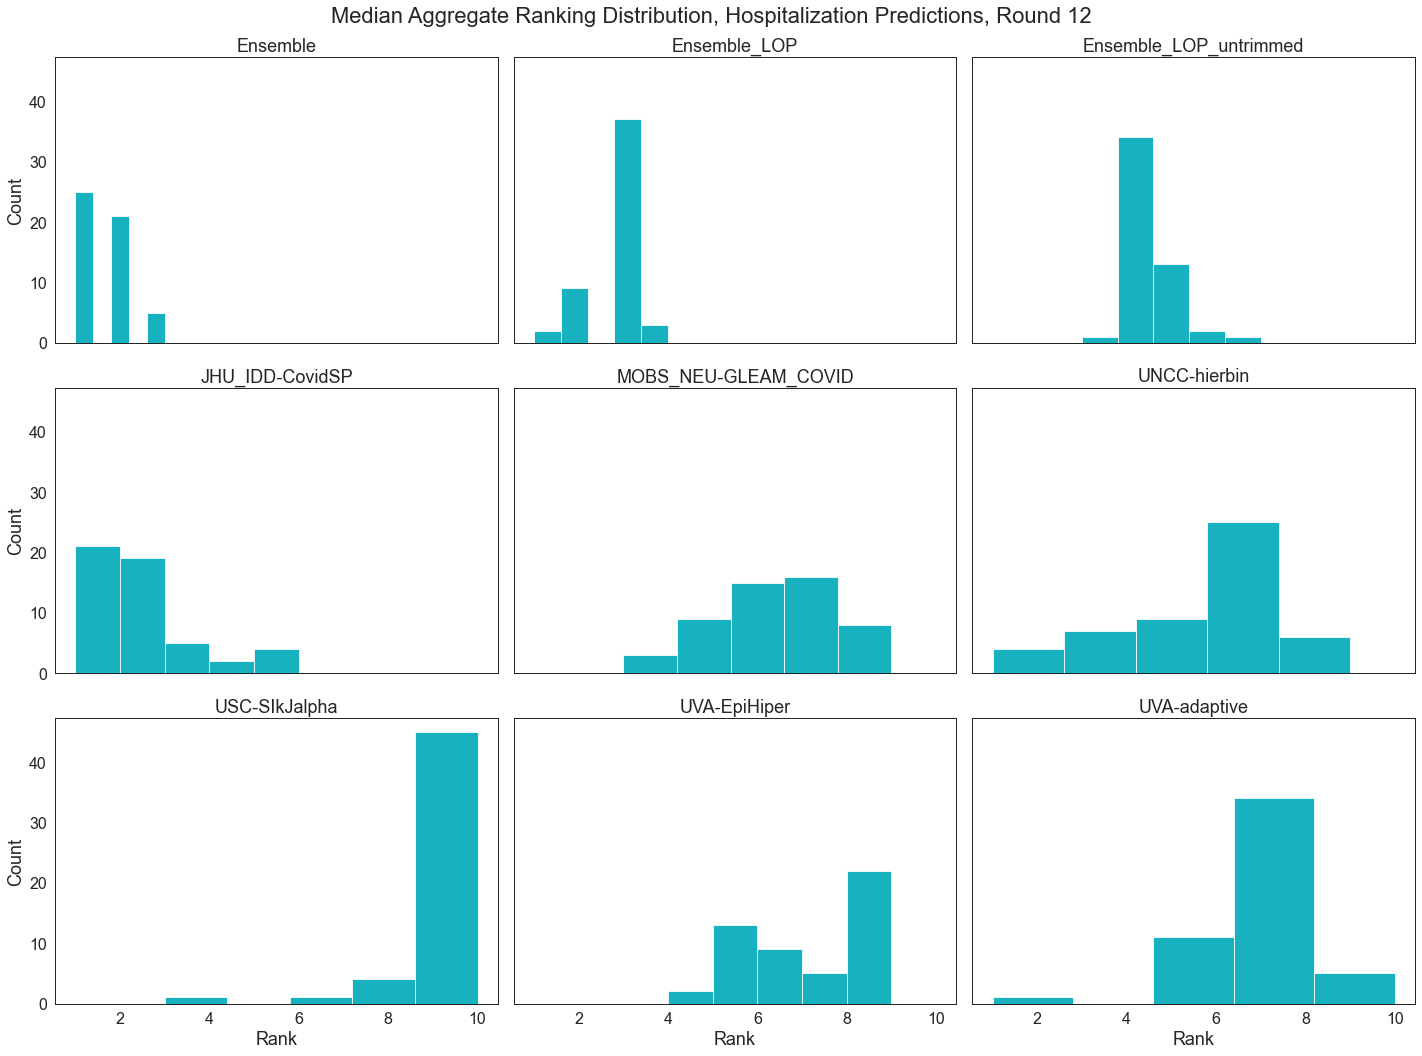

In [613]:

plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_hosp.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Hospitalization Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('hosp_rd12_rankings.pdf')
plt.show()

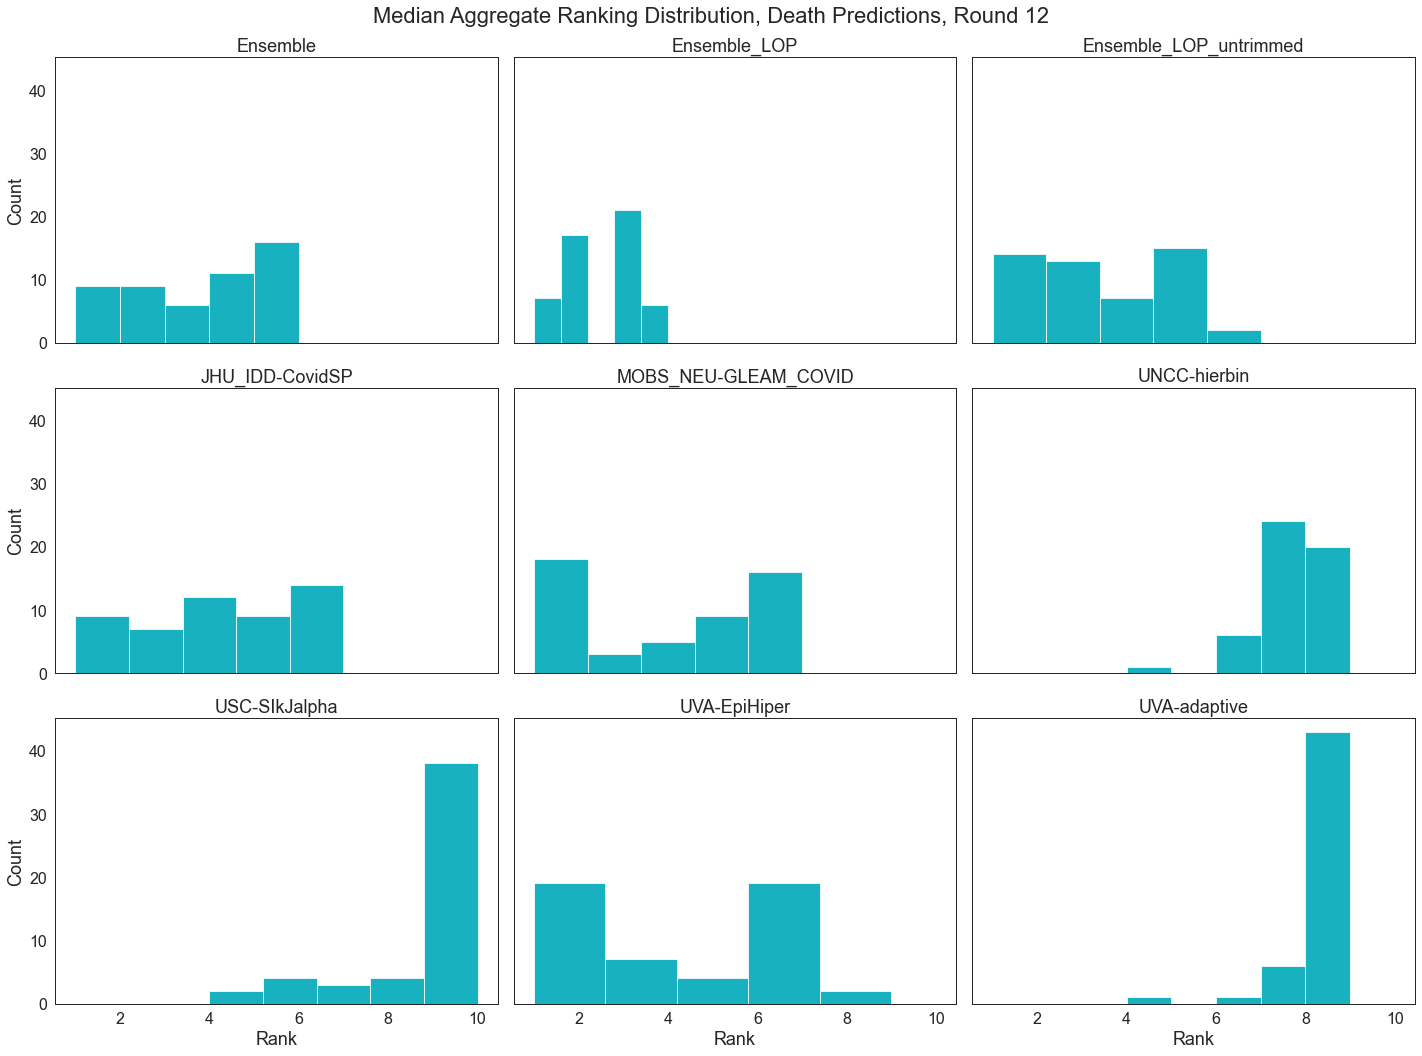

In [603]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_death.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Death Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('death_rd12_rankings.pdf')
plt.show()

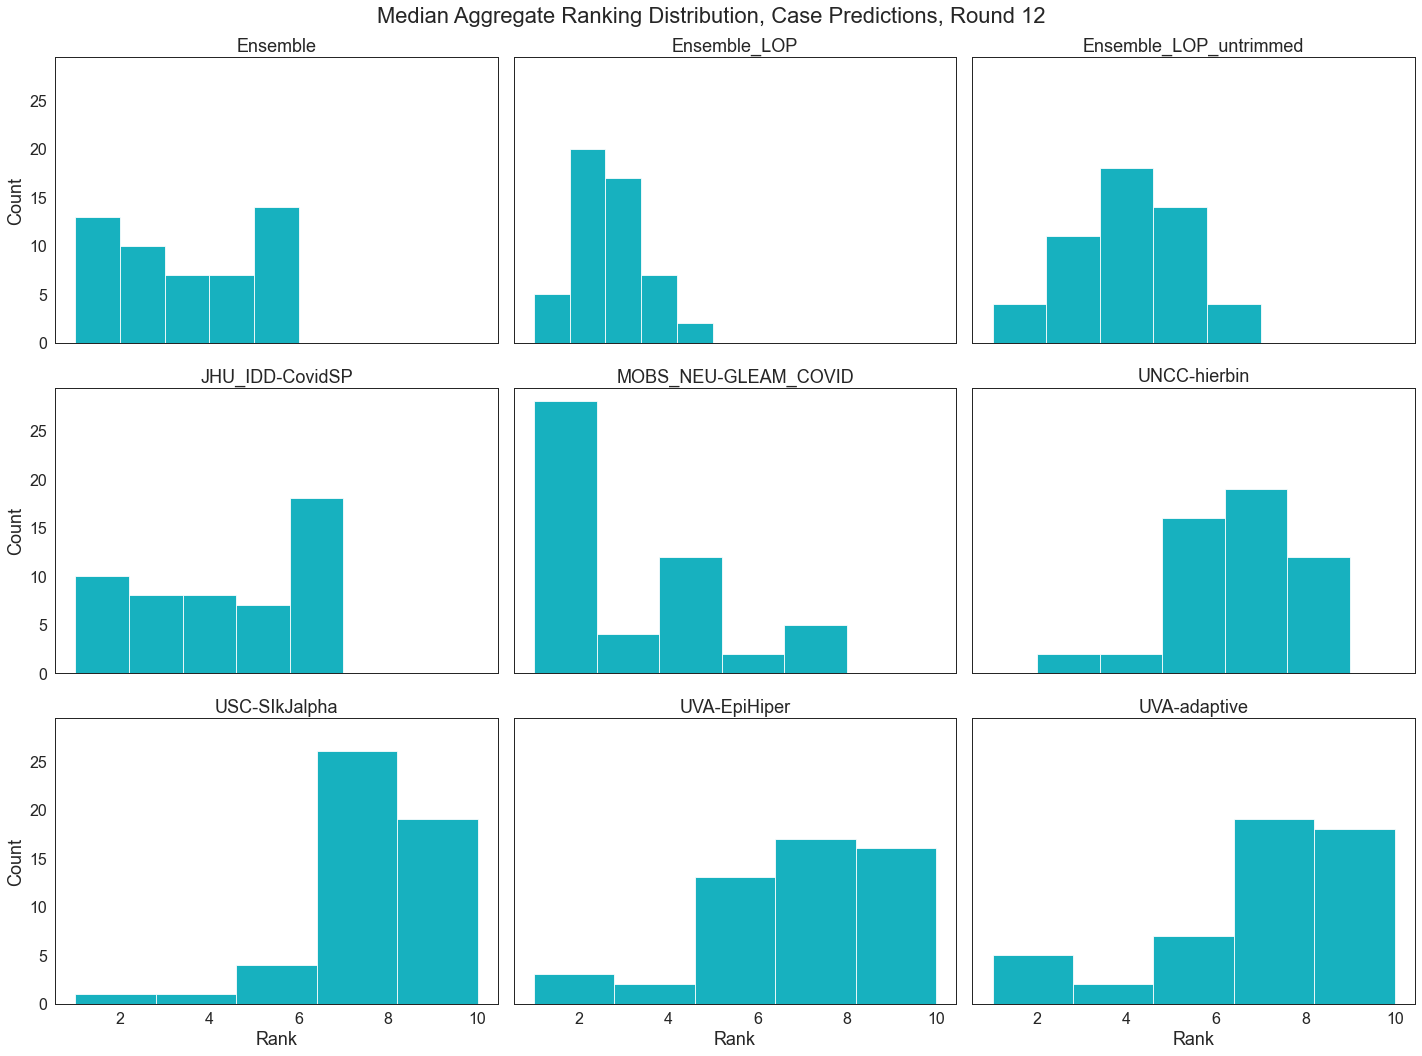

In [606]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_case.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Case Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('case_rd12_rankings.pdf')
plt.show()

In [608]:
dfrank_all = pd.concat([dfrank_hosp, dfrank_case, dfrank_death])
dfrank_all = dfrank_all.reset_index()

In [597]:
dfrank_all

,index,Model,Location,Rank
0,0,Ensemble,Alabama,2
1,1,Ensemble_LOP,Alabama,3
2,2,Ensemble_LOP_untrimmed,Alabama,4
3,3,JHU_IDD-CovidSP,Alabama,5
4,4,MOBS_NEU-GLEAM_COVID,Alabama,1
...,...,...,...,...
1372,454,MOBS_NEU-GLEAM_COVID,Wyoming,1
1373,455,UNCC-hierbin,Wyoming,6
1374,456,USC-SIkJalpha,Wyoming,9
1375,457,UVA-EpiHiper,Wyoming,8


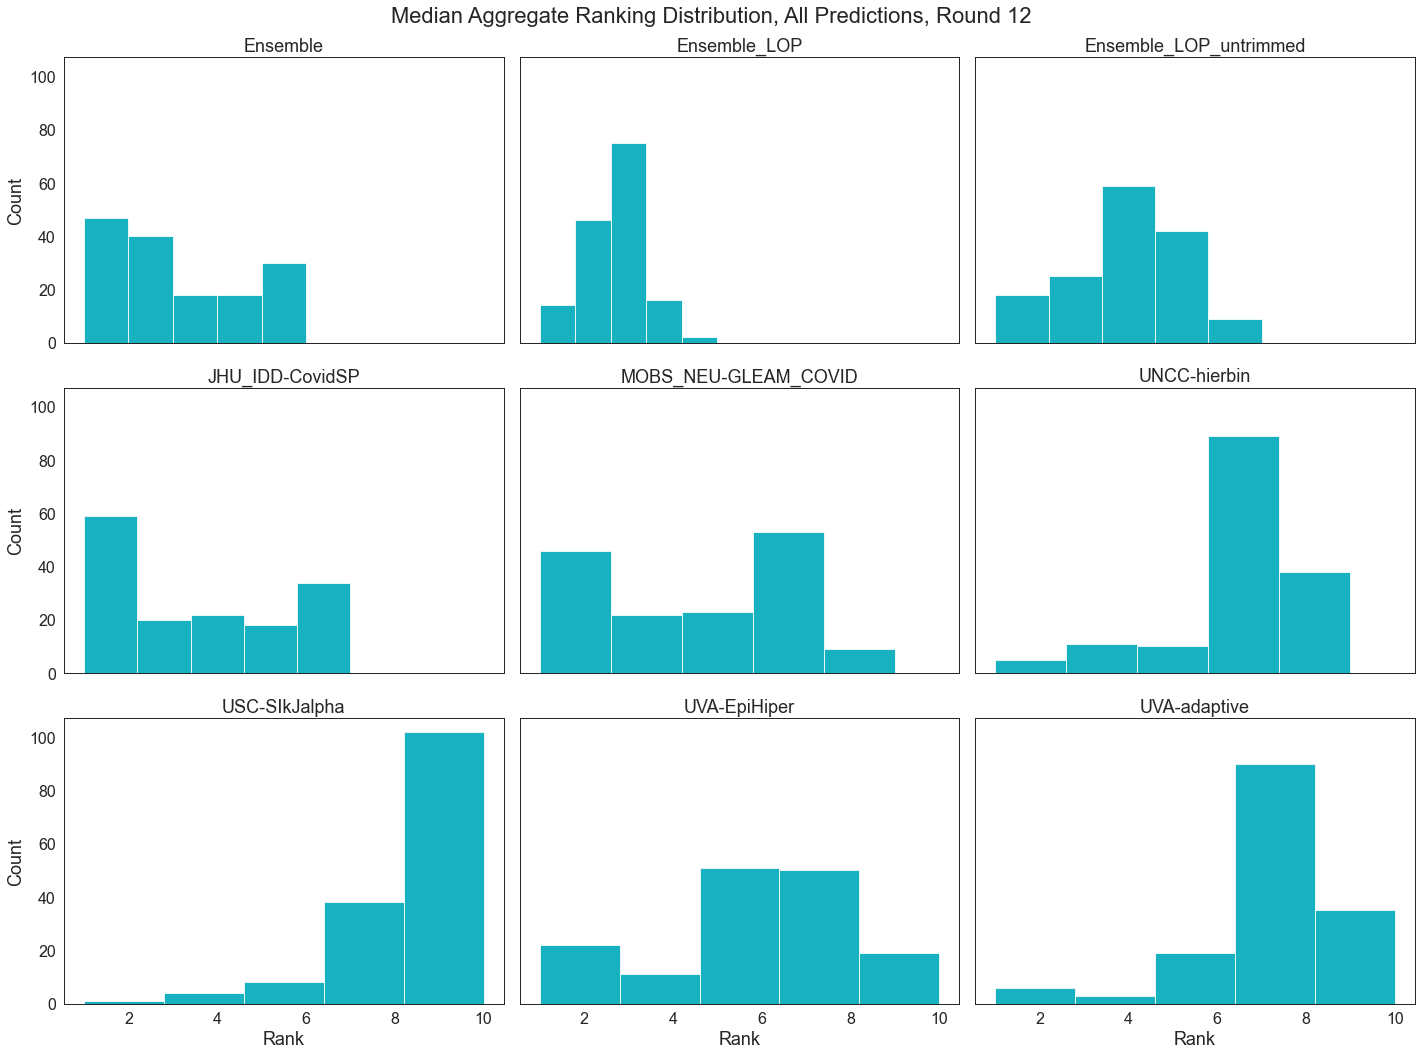

In [614]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_all.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, All Predictions, Round 12", fontsize=22)
plt.tight_layout()
plt.savefig('all_rd12_rankings.pdf')
plt.show()

In [558]:
dftab = df_all_hosp[df_all_hosp['Location']=='Massachusetts']
dftab = dftab.drop(['Location', 'Population'], axis=1).reset_index()
dftab = dftab.drop(['index'], axis=1)

dftab.style.set_caption("Round 12 Hospitalizations, location = MA")

,Model,WIS,50% Coverage,95% Coverage
0,Ensemble,230.333895,0.333333,0.666667
1,Ensemble_LOP,214.235047,1.000000,1.000000
2,Ensemble_LOP_untrimmed,278.319468,1.000000,1.000000
3,JHU_IDD-CovidSP,429.109955,0.000000,0.444444
4,MOBS_NEU-GLEAM_COVID,411.623121,0.333333,0.666667
5,UNCC-hierbin,182.804204,0.555556,0.666667
6,USC-SIkJalpha,1882.408106,0.111111,0.111111
7,UTA-ImmunoSEIRS,396.106762,0.000000,0.222222
8,UVA-EpiHiper,795.905103,0.222222,0.666667
9,UVA-adaptive,393.542616,0.222222,0.555556


In [525]:
dftab.columns

Index(['Model', 'WIS', '50% Coverage', '95% Coverage', 'Location',
       'Population'],
      dtype='object')

In [552]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = ['US']

rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = datetime.datetime(2022, 3, 15)
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]


median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['Model', 'WIS','50% Coverage','95% Coverage', 'Location', 'Population'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    #target = 'death'
    target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    


    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location == 'US']
            #predictions = predictions.astype({'location':'int'})
            
            
            #locations = locations[locations.location != 'US']
            #locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = target_location
            
            pred = predictions[predictions['location'] == 'US'].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            
            
            labels = ["Median aggregate"]


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            for label in labels:
                aggregated_data['Case'] += [label]
                aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
                aggregated_data['Cov50'] += [aggregated_scores[label]['50_cov']]
                aggregated_data['Cov95'] += [aggregated_scores[label]['95_cov']]

            agg_data_df = pd.DataFrame(aggregated_data)
            agg_data_df['Model'] = model
            wisval = agg_data_df.WIS[0]
            cov50val = agg_data_df.Cov50[0]
            cov95val = agg_data_df.Cov95[0]

            
            locname = list(pred.location_name.unique())[0]
            popsize = list(pred.population.unique())[0]


            new_row = {'Model':model, 'WIS':wisval,'50% Coverage':cov50val, '95% Coverage':cov95val,
                       'Location': locname, 'Population': popsize}
 
            df = df.append(new_row, ignore_index=True)
                    
        except Exception as e:
            print(e)    
    


/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2598479091.py:48: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

There are no predictions for model NCSU-COVSIM at location US
There are no predictions for model NotreDame-FRED at location US


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

There are no predictions for model UTA-ImmunoSEIRS at location US


/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

In [555]:
median_ensembles_us_hosp = median_ensembles
extreme_ensembles_us_hosp = extreme_ensembles

df_us_hosp = df

In [557]:
dftab = df_us_hosp.drop(['Location', 'Population'], axis=1).reset_index()
dftab = dftab.drop(['index'], axis=1)

dftab.style.set_caption("Round 12 Hospitalization, location = US")

,Model,WIS,50% Coverage,95% Coverage
0,Ensemble,13066.221771,0.333333,0.666667
1,Ensemble_LOP,16361.426119,1.000000,1.000000
2,Ensemble_LOP_untrimmed,22139.663518,1.000000,1.000000
3,JHU_IDD-CovidSP,19176.009223,0.000000,0.222222
4,MOBS_NEU-GLEAM_COVID,21376.951609,0.444444,0.777778
5,UNCC-hierbin,42247.407322,0.000000,0.111111
6,USC-SIkJalpha,98228.447749,0.111111,0.111111
7,UVA-EpiHiper,131385.464947,0.000000,0.000000
8,UVA-adaptive,29267.093478,0.111111,0.333333


# Coverage table averaged over locations

In [629]:
df_all_hosp.Model.unique()


array(['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
       'JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 'UNCC-hierbin',
       'USC-SIkJalpha', 'UVA-EpiHiper', 'UVA-adaptive', 'UTA-ImmunoSEIRS'],
      dtype=object)

In [632]:
testdf = df_all_hosp.copy()

In [646]:
avgscoresdf = pd.DataFrame(columns=['Model', 'Average WIS','Average 50% Coverage','Average 95% Coverage'])

testdf = testdf[testdf.Model == 'Ensemble']
testdf['normWIS'] = testdf['WIS']/testdf['Population']
avgWIS = testdf.normWIS.mean()
avgcov50 = testdf['50% Coverage'].mean()
avgcov95 = testdf['95% Coverage'].mean()

new_row = {'Model':'ensemble', 'Average WIS':avgWIS,'Average 50% Coverage':avgcov50,'Average 95% Coverage':avgcov95 }

avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2045713969.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)


In [672]:
df = df_all_case.copy()
models = list(df.Model.unique())

avgscoresdf = pd.DataFrame(columns=['Model', 'Average WIS','Average 50% Coverage','Average 95% Coverage'])


for model in models:
    
    testdf = df[df.Model == model]
    testdf['normWIS'] = testdf['WIS']/testdf['Population']
    avgWIS = testdf.normWIS.mean()
    avgcov50 = testdf['50% Coverage'].mean()
    avgcov95 = testdf['95% Coverage'].mean()

    
    new_row = {'Model':model, 'Average WIS':avgWIS,'Average 50% Coverage':avgcov50,'Average 95% Coverage':avgcov95 }

    avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)
    

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2695709199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdf['normWIS'] = testdf['WIS']/testdf['Population']
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2695709199.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)
/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2695709199.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [673]:
avgscoresdf.style.set_caption("Round 12 Cases, average scores over all locations")

,Model,Average WIS,Average 50% Coverage,Average 95% Coverage
0,Ensemble,0.003350,0.281046,0.666667
1,Ensemble_LOP,0.003180,0.562092,0.984749
2,Ensemble_LOP_untrimmed,0.003600,0.712418,0.997821
3,JHU_IDD-CovidSP,0.003733,0.516340,0.989107
4,MOBS_NEU-GLEAM_COVID,0.002677,0.215686,0.525054
5,UNCC-hierbin,0.006037,0.039216,0.113290
6,USC-SIkJalpha,0.010523,0.098039,0.267974
7,UVA-EpiHiper,0.008608,0.113290,0.261438
8,UVA-adaptive,0.011176,0.148148,0.411765
9,UTA-ImmunoSEIRS,0.002200,0.138889,0.444444


# Coverage plot

In [720]:
median_ensembles = dict()
extreme_ensembles = dict()

coveragedf = pd.DataFrame(columns=['Model', '10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                         '80_cov', '90_cov', '95_cov', '98_cov', 'Location', 'Case'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    #target = 'death'
    target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme Aggregate"]

        


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            
            coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                         '80_cov', '90_cov', '95_cov', '98_cov']
            for label in ["Median aggregate"]:
                aggregated_data['Case'] += [label]
                
                for cv in coverages:
                
                    aggregated_data[cv] += [aggregated_scores[label][cv]]
                
                agg_data_df = pd.DataFrame(aggregated_data)
                agg_data_df['Model'] = model
                agg_data_df['Location'] = l
                

            
            
            
            
            
            coveragedf = pd.concat([coveragedf, agg_data_df])
            
            
  
        except Exception as e:
            print(e)    
    


/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/1062206125.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to Fal

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:32: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions = all_predictions.groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:63: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_predictions_med = all_predictions[np.isclose(all_predictions[quantile_col],0.5)].groupby(
/Users/clara/Documents/GitHub/scorepi/scorepi/ensemble_models.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify n

In [ ]:
coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov']

In [721]:
coveragedf_hosp = coveragedf

In [722]:
coveragedf_hosp

,Model,10_cov,20_cov,30_cov,40_cov,50_cov,60_cov,70_cov,80_cov,90_cov,95_cov,98_cov,Location,Case
0,Ensemble,0.000000,0.000000,0.000000,0.222222,0.222222,0.444444,0.444444,0.666667,0.666667,1.000000,1.000000,01,Median aggregate
0,Ensemble_LOP,0.000000,0.000000,0.111111,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,01,Median aggregate
0,Ensemble_LOP_untrimmed,0.000000,0.111111,0.444444,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,01,Median aggregate
0,JHU_IDD-CovidSP,0.000000,0.000000,0.000000,0.111111,0.111111,0.111111,0.222222,0.444444,1.000000,1.000000,1.000000,01,Median aggregate
0,MOBS_NEU-GLEAM_COVID,0.111111,0.222222,0.222222,0.222222,0.222222,0.333333,0.333333,0.555556,0.555556,0.555556,0.666667,01,Median aggregate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MOBS_NEU-GLEAM_COVID,0.111111,0.111111,0.111111,0.111111,0.111111,0.222222,0.333333,0.444444,0.777778,0.777778,1.000000,56,Median aggregate
0,UNCC-hierbin,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.222222,0.222222,56,Median aggregate
0,USC-SIkJalpha,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.111111,0.111111,0.222222,0.222222,0.333333,56,Median aggregate
0,UVA-EpiHiper,0.000000,0.000000,0.111111,0.222222,0.222222,0.222222,0.222222,0.333333,0.444444,0.444444,0.666667,56,Median aggregate


In [806]:
df = coveragedf_death.copy()
models = list(df.Model.unique())
#models = models[0:-2]

avgcov = {}

for model in models:
    testdf = df[df.Model == model]
    avgcov[model] = []
    
    for cv in coverages:
        cov = testdf[cv].mean()
        avgcov[model].append(cov)

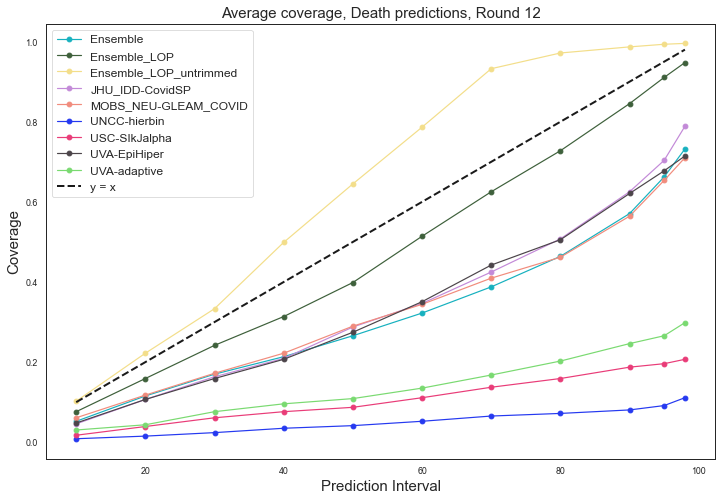

In [813]:
plt.figure(figsize=(12,8))

covers = [10,20,30,40,50,60,70,80,90,95,98]
covsy = [cv/100 for cv in covers]

for model in models:
    plt.plot(covers, avgcov[model],'-o', label=model)
    
plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2)  

plt.xlabel('Prediction Interval', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.title('Average coverage, Death predictions, Round 12', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('coverage_interval_death_rd12.pdf')
plt.show()


In [724]:
list(df.Model.unique())

['Ensemble',
 'Ensemble_LOP',
 'Ensemble_LOP_untrimmed',
 'JHU_IDD-CovidSP',
 'MOBS_NEU-GLEAM_COVID',
 'UNCC-hierbin',
 'USC-SIkJalpha',
 'UVA-EpiHiper',
 'UVA-adaptive']

In [733]:
list(np.linspace(0,1,len(covers)))

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]